In [3]:
using DataFrames
using Gadfly
set_default_plot_size(40cm, 14cm)

home_gram = "/home/german/labo/18/egfr/renonmis_gram"
home_modos = "/home/german/labo/18/egfr/modos"
home_rtdos = "/home/german/labo/18/egfr/rtdos_log"
aa = 277

277

In [43]:
function colectividad(in_vec::Array{Float64, 1})
    return exp(-sum(in_vec .^2 .* log.(in_vec .^2))) ./ length(in_vec)
end

colectividad (generic function with 1 method)

In [53]:
function WeightedHist(in_vec, in_bins, in_weight, density = false)
    # Safety check    
    if length(in_vec) != length(in_weight)
        println("Each element of the input vector needs one weight")
        return
    end
    
    # Prepare variables
    out_counts = Array{Float64}(length(in_bins)-1)
    
    # Get weighted histogram
    for i=1:length(in_bins)-1
        if i == 1
            # Include those that fall before the beggining of the bins
            temp_bool = (in_vec .>= in_bins[i]) .& (in_vec .< in_bins[i+1]) .| (in_vec .<= in_bins[i])
            out_counts[i] = sum(in_weight[temp_bool])
        elseif i == length(in_bins)-1
            # Include those that fall after the end of the bins
            temp_bool = (in_vec .>= in_bins[i]) .& (in_vec .< in_bins[i+1]) .| (in_vec .>= in_bins[end])
            out_counts[i] = sum(in_weight[temp_bool])
        else
            temp_bool = (in_vec .>= in_bins[i]) .& (in_vec .< in_bins[i+1])
            out_counts[i] = sum(in_weight[temp_bool])
        end
    end
    
    # Get bins middle points
    out_middle = (in_bins[1:end-1] + in_bins[2:end]) / 2
    
    # Turn counts into density
    if (density == true)
        out_counts = out_counts ./ sum(out_counts) 
    end
    return out_counts, out_middle
end

WeightedHist (generic function with 2 methods)

In [4]:
# Leo nombres de structuras
tmp = readdlm(joinpath(home_gram, "pdbs.list"))
pdbs_list = convert(Array{String, 1}, reshape(tmp, length(tmp)));
aa = 277
aa_3 = aa * 3
aa_36 = aa_3 - 6
n_pdbs = length(pdbs_list)

# Leo activas e inactivas
tmp = readdlm(joinpath(home_gram, "am.list"))
am_list = convert(Array{String, 1}, reshape(tmp, length(tmp)));

tmp = readdlm(joinpath(home_gram, "im.list"))
im_list = convert(Array{String, 1}, reshape(tmp, length(tmp)));

In [35]:
modos = Array{Array{Float64, 2}}(n_pdbs)
freqs = Array{Array{Float64, 1}}(n_pdbs)

for i = 1:n_pdbs
    each = pdbs_list[i]
    modos[i] = readdlm(joinpath(home_modos, each, string("modos_", each)))
    # Algunos elementos son nulos y me cagan el cálculo de colectividad.
    # Les asigno un valor mínimo p/ evitar esto.
    modos[i][find(modos[i] .== 0)] .=  1e-8
    
    freqs[i] = convert(Array{Float64}, readdlm(joinpath(home_modos, each, string("freq_", each)))[8:end, 1])
end

In [51]:
# IM
κ_im_1 = Array{Float64}(length(im_list))
κ_im_2 = Array{Float64}(length(im_list))
κ_im_3 = Array{Float64}(length(im_list))

for i = 1:length(im_list)
    each = im_list[i]

    κ_im_1[i] = colectividad(modos[i][:, 1])
    κ_im_2[i] = colectividad(modos[i][:, 2])
    κ_im_3[i] = colectividad(modos[i][:, 3])
end

# AM
κ_am_1 = Array{Float64}(length(am_list))
κ_am_2 = Array{Float64}(length(am_list))
κ_am_3 = Array{Float64}(length(am_list))

for i = 1:length(am_list)
    each = am_list[i]

    κ_am_1[i] = colectividad(modos[i][:, 1])
    κ_am_2[i] = colectividad(modos[i][:, 2])
    κ_am_3[i] = colectividad(modos[i][:, 3])
end

In [73]:
# Vec 1
hbins = collect(minimum(κ_am_1)+.1:.01:maximum(κ_am_1))
hweights_im = repeat([1.0], inner = [length(κ_im_1)])
hweights_am = repeat([1.0], inner = [length(κ_am_1)])

counts_im, bins = WeightedHist(κ_im_1, hbins, hweights_im, true)
counts_am, bins = WeightedHist(κ_am_1, hbins, hweights_am, true)


df_κ_1 = DataFrame(Probability = [counts_am ; counts_im],
    κ = [ bins ; bins ],
    Conformer = repeat(["AM" ; "IM"], inner = [ length(bins)]));

# Vec 2
hbins = collect(minimum(κ_am_2)+.1:.01:maximum(κ_am_2))
hweights_im = repeat([1.0], inner = [length(κ_im_2)])
hweights_am = repeat([1.0], inner = [length(κ_am_2)])

counts_im, bins = WeightedHist(κ_im_2, hbins, hweights_im, true)
counts_am, bins = WeightedHist(κ_am_2, hbins, hweights_am, true)


df_κ_2 = DataFrame(Probability = [counts_am ; counts_im],
    κ = [ bins ; bins ],
    Conformer = repeat(["AM" ; "IM"], inner = [ length(bins)]));

# Vec 3
hbins = collect(minimum(κ_am_3)+.02:.01:maximum(κ_am_3))
hweights_im = repeat([1.0], inner = [length(κ_im_3)])
hweights_am = repeat([1.0], inner = [length(κ_am_3)])

counts_im, bins = WeightedHist(κ_im_3, hbins, hweights_im, true)
counts_am, bins = WeightedHist(κ_am_3, hbins, hweights_am, true)


df_κ_3 = DataFrame(Probability = [counts_am ; counts_im],
    κ = [ bins ; bins ],
    Conformer = repeat(["AM" ; "IM"], inner = [ length(bins)]));

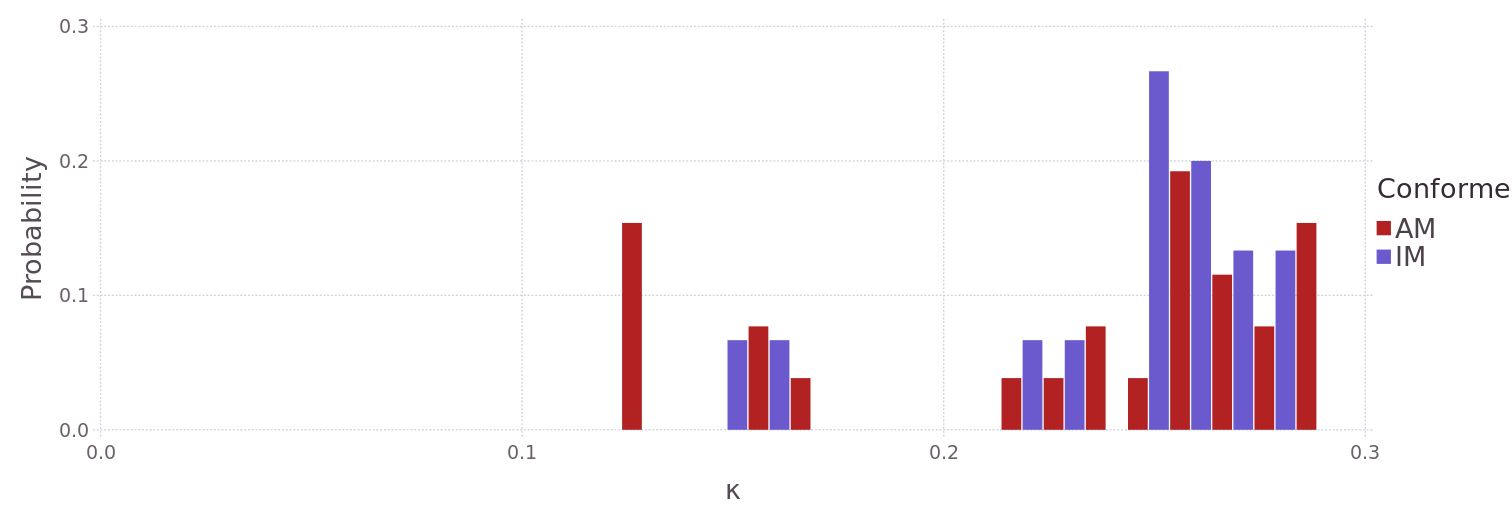

In [65]:
pdf_κ_1 = plot(df_κ_1, x="κ", y="Probability", color = "Conformer", 
    Geom.bar(position = :dodge),

    #Guide.title("Figure 2.AA"),
    #Guide.ylabel("δV * Probability", orientation=:vertical), 
    #Guide.yticks(ticks = collect(0.25:0.25:1.0)),
    #Coord.cartesian(xmin = 0, xmax = 15),
    Scale.color_discrete_manual("Firebrick","SlateBlue"),


    Theme(bar_spacing = 2pt, grid_line_width=1pt, key_label_font_size = 20pt,
        minor_label_font_size = 14pt, major_label_font_size = 20pt, key_title_font_size = 20pt))

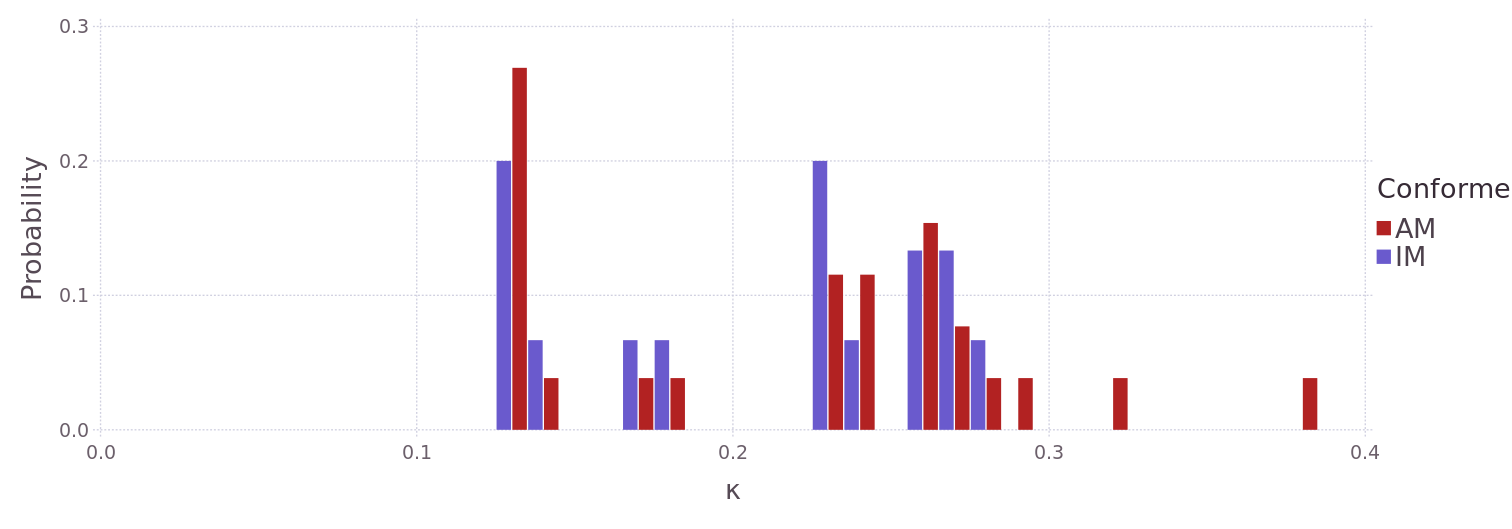

In [76]:
pdf_κ_2 = plot(df_κ_2, x="κ", y="Probability", color = "Conformer", 
    Geom.bar(position = :dodge),

    #Guide.title("Figure 2.AA"),
    #Guide.ylabel("δV * Probability", orientation=:vertical), 
    #Guide.yticks(ticks = collect(0.25:0.25:1.0)),
    #Coord.cartesian(xmin = 0, xmax = 15),
    Scale.color_discrete_manual("Firebrick","SlateBlue"),


    Theme(bar_spacing = 2pt, grid_line_width=1pt, key_label_font_size = 20pt,
        minor_label_font_size = 14pt, major_label_font_size = 20pt, key_title_font_size = 20pt))

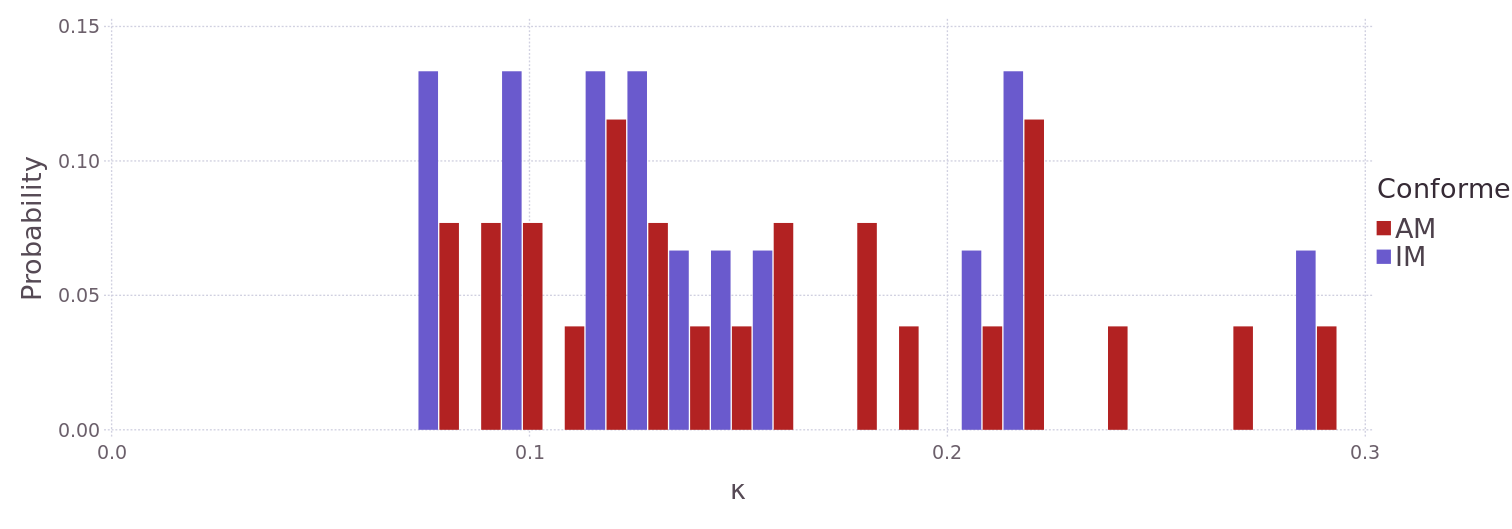

In [75]:
pdf_κ_3 = plot(df_κ_3, x="κ", y="Probability", color = "Conformer", 
    Geom.bar(position = :dodge),

    #Guide.title("Figure 2.AA"),
    #Guide.ylabel("δV * Probability", orientation=:vertical), 
    #Guide.yticks(ticks = collect(0.25:0.25:1.0)),
    #Coord.cartesian(xmin = 0, xmax = 15),
    Scale.color_discrete_manual("Firebrick","SlateBlue"),


    Theme(bar_spacing = 2pt, grid_line_width=1pt, key_label_font_size = 20pt,
        minor_label_font_size = 14pt, major_label_font_size = 20pt, key_title_font_size = 20pt))